#Helper functions:

In [0]:
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
plt.rcParams["figure.figsize"] = (5, 5) # (w, h)
import numpy as np
import cv2
import glob
from numpy import linalg as LA
from sklearn import preprocessing
from collections import Counter
import pickle


In [0]:
# funcrion to read and resize an image
def read_and_resize_image(filename, grayscale = False, fx= 0.5, fy=0.5):
    if grayscale:
      img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
      img_result = cv2.bitwise_not(img_result)
    else:
      imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
      # convert to rgb
      img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    # resize
    img_result = cv2.resize(img_result, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
    return img_result

In [0]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalcatface.xml
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalcatface_extended.xml
clear_output()
print('Download completed!')
!ls

#Training :

##Read training images

408
408


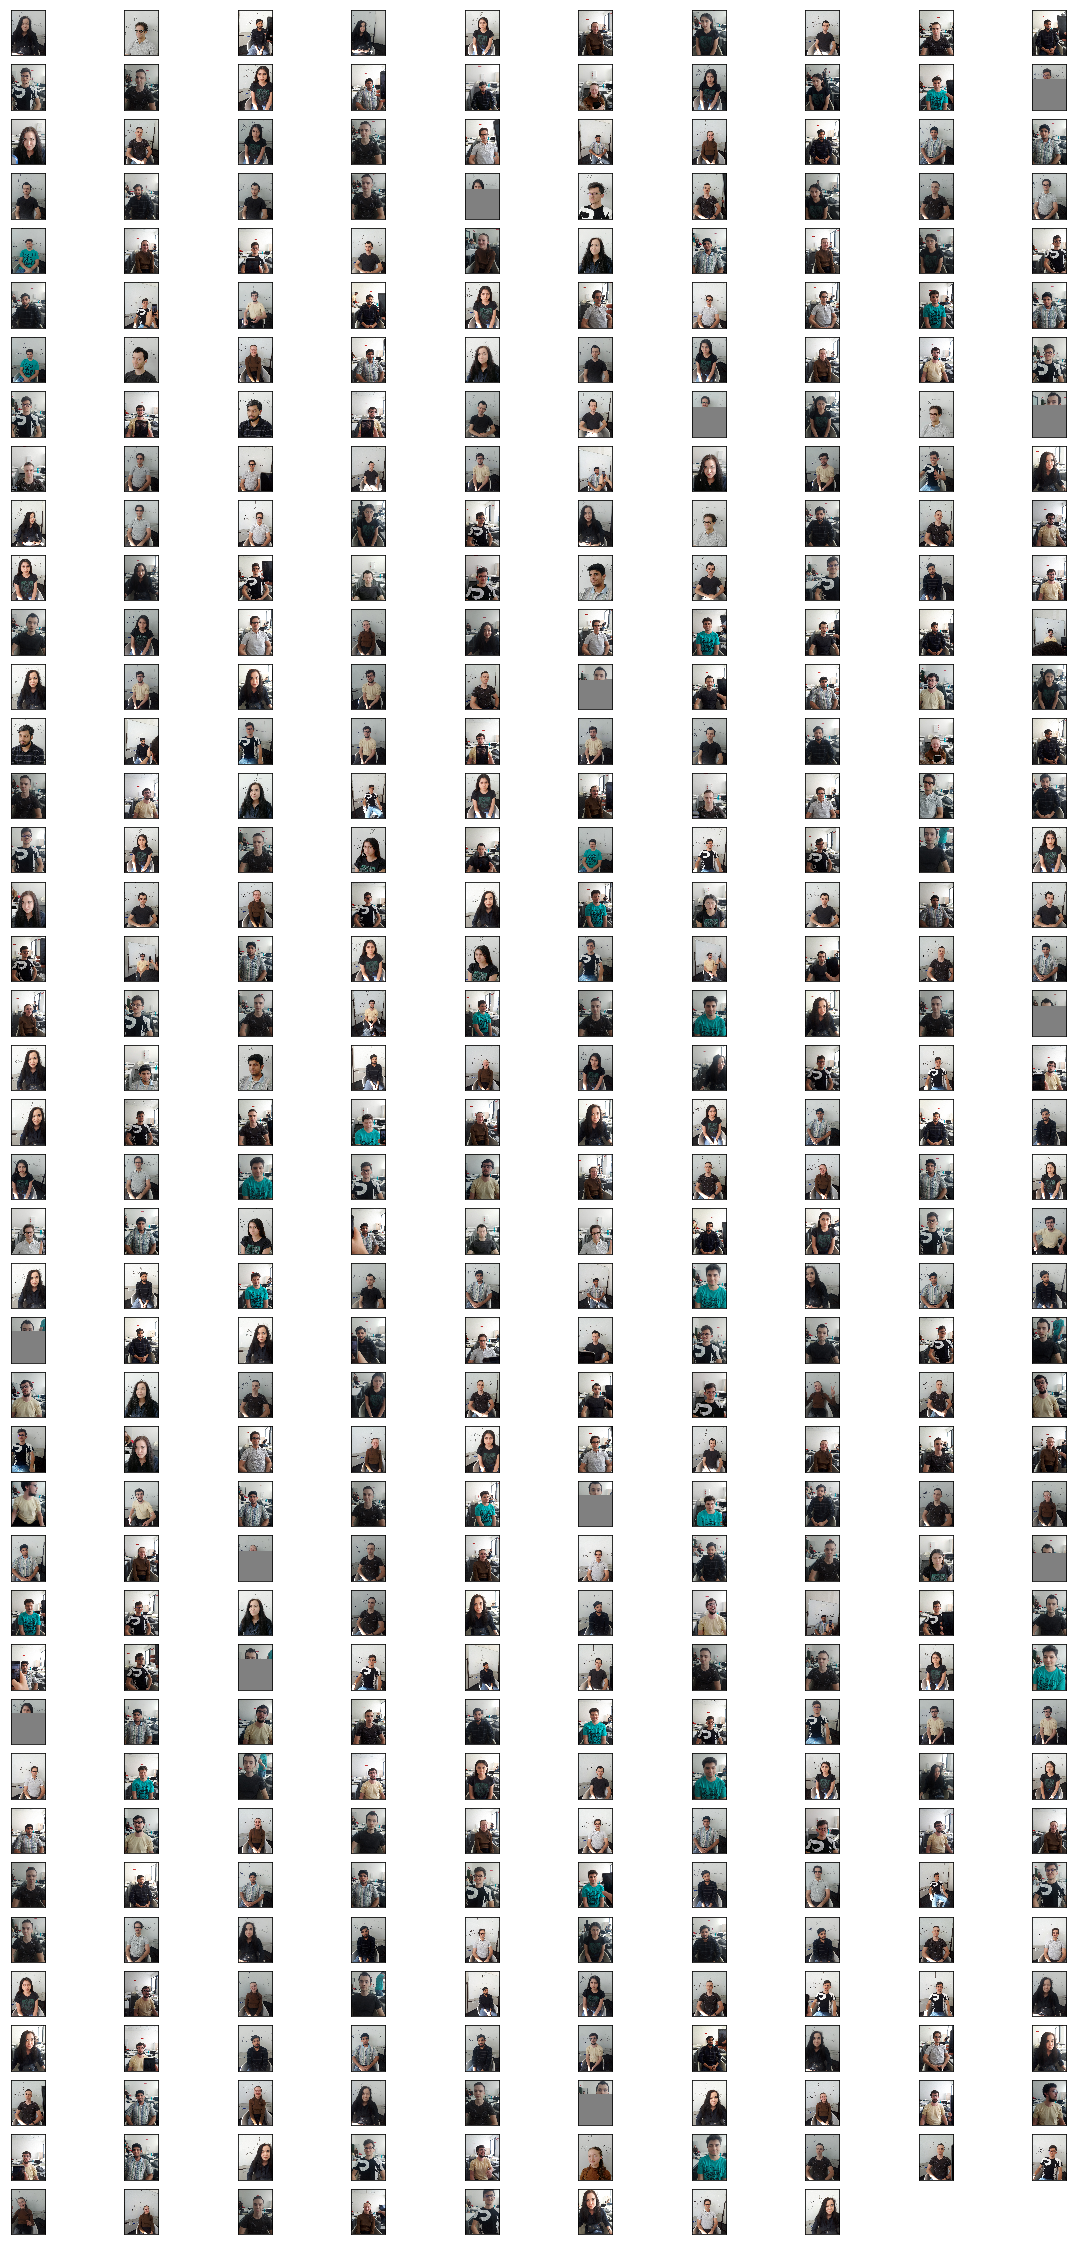

In [0]:
##################### reading training images #################################
list_of_files = glob.glob('*.jpg')           # create the list of file
imgs=[]
ids_source = []
images = []
plt.figure(figsize=(20,80))
j=0
for i, image in enumerate(list_of_files):
  if image.split('_')[0]!='test':  
    imgs.append(read_and_resize_image(image, grayscale = False, fx= 1, fy=1))
    images.append(image)
    ids_source.append( int( image.split('_')[0] ) )
    
    plt.subplot(int(len(list_of_files)/10)+1, 10 ,  j+1)
    plt.imshow(imgs[-1], 'gray')
    plt.xticks([]),plt.yticks([])
    j+=1
  
print(len(imgs))
print(len(ids_source))
plt.show()

##Detection using Viola Jones

In [0]:
########################## detecting faces ###################################
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
roi_color_images =[]
roi_gray_images =[]
ids_detected = {}
j=0
for i, img in enumerate(imgs):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  if len(faces)==0:
    ids_source[i] = -1
  else:
    for (x,y,w,h) in faces:
#       cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
      roi_gray = gray[y:y+h, x:x+w]
      roi_color = img[y:y+h, x:x+w]
      roi_color_images.append(roi_color)
      roi_gray_images.append(roi_gray)
      
      ids_detected[j] = images[i]
      j+=1
      if len(faces) > 1:
        break

ids = [ id for id in ids_source if id !=-1]
print(len(ids))
print(len(roi_color_images))
ids = np.array(ids)
########################  printing faces ######################################
plt.figure(figsize=(20,40))
for i in range(len(roi_color_images)):      
  plt.subplot(int(len(roi_color_images)/10)+1, 10 ,  i+1)
  plt.imshow(roi_color_images[i], 'gray')
  plt.title('{}'.format(ids_detected[i]))
  plt.xticks([]),plt.yticks([])
plt.show()

##Detection using deep learning

400
400
400


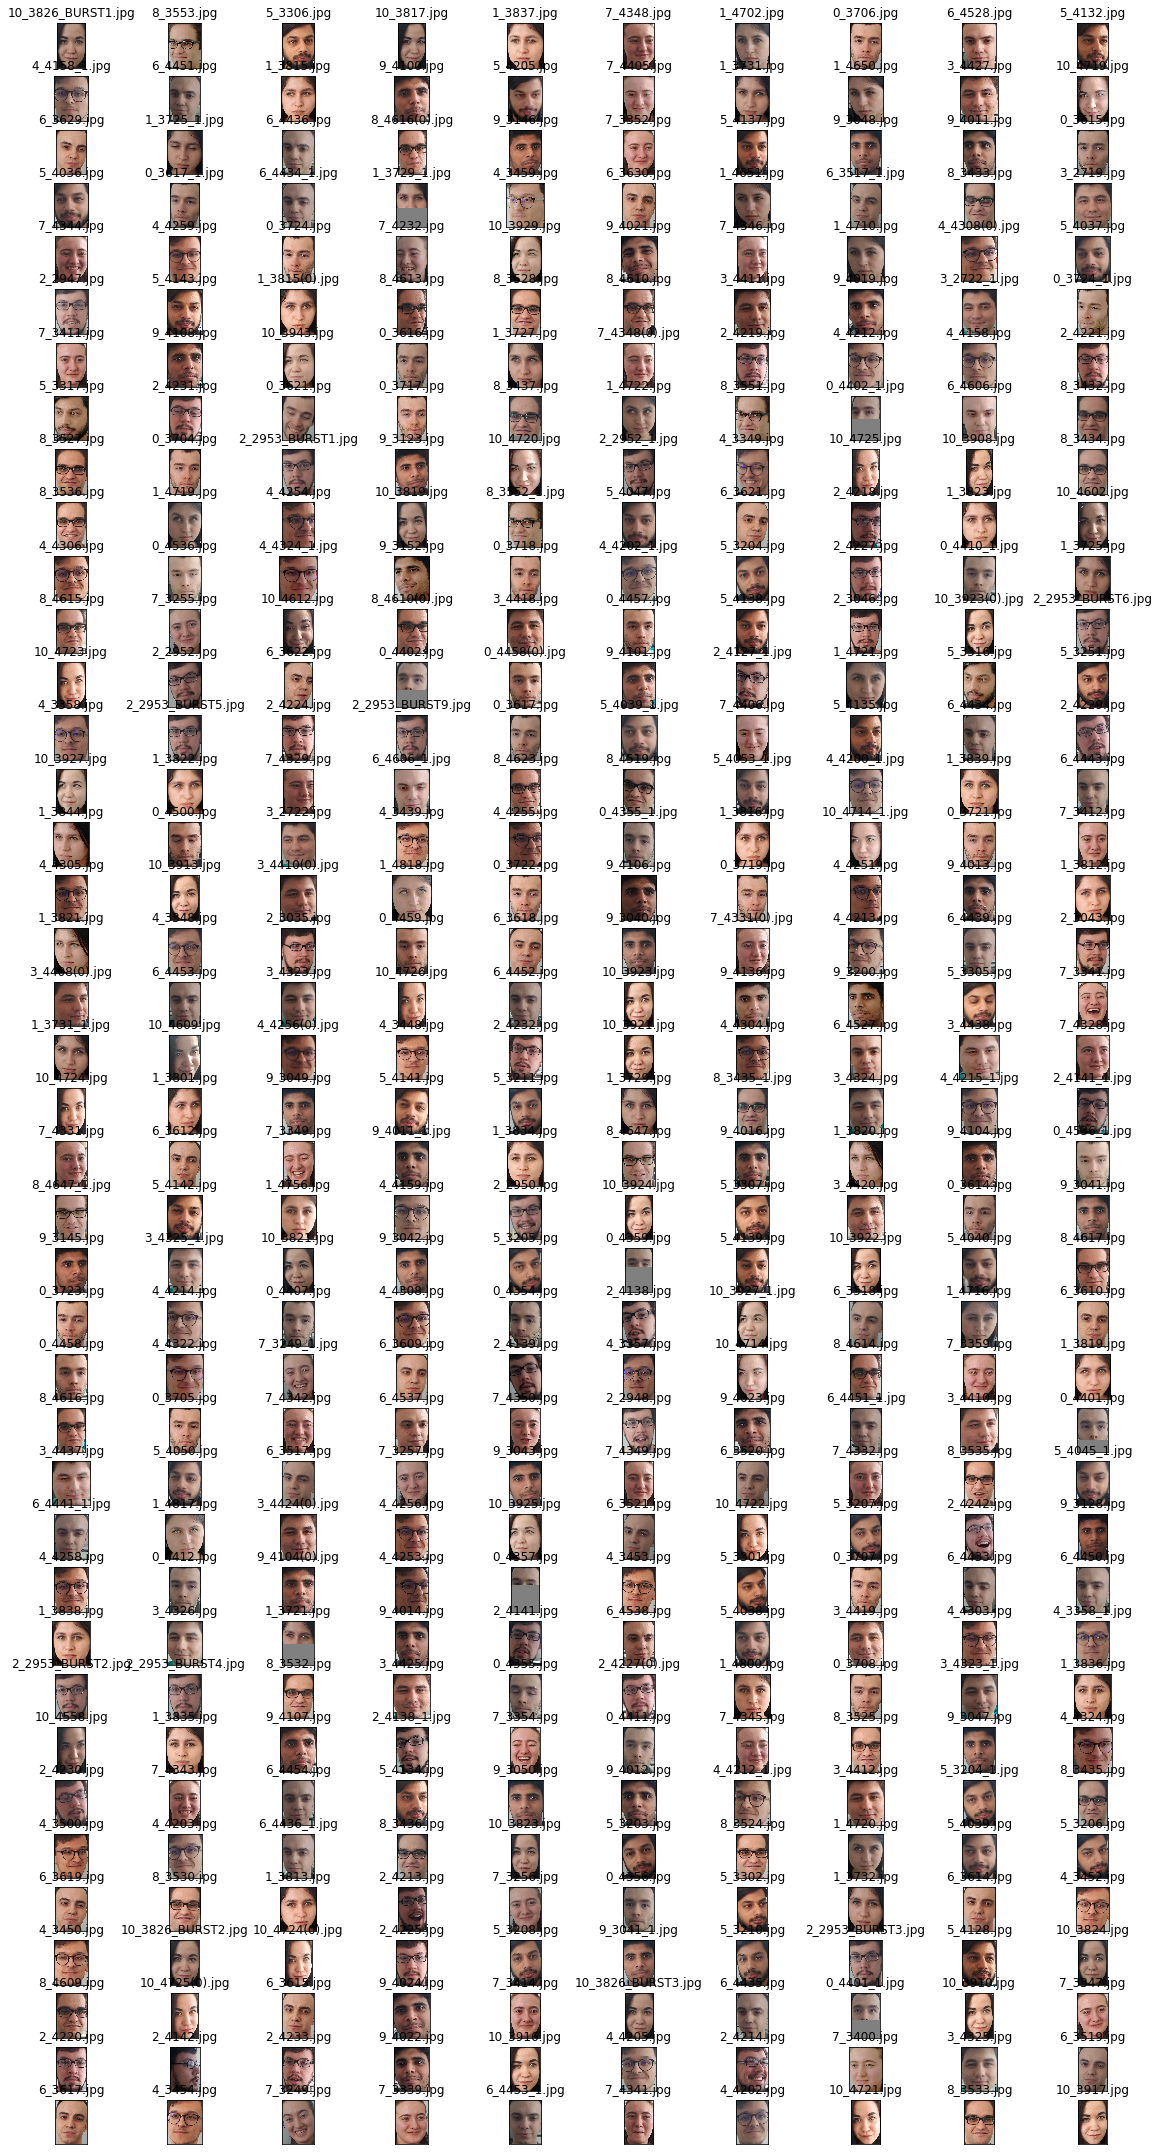

In [0]:
modelFile = "opencv_face_detector_uint8.pb"
configFile = "opencv_face_detector.pbtxt"
net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)
roi_color_images =[]
roi_gray_images =[]
conf_threshold = 0.9
ids_detected = images

for i, img in enumerate(imgs):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  (h, w) = img.shape[:2]
  blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), [104, 117, 123], False, False)
  net.setInput(blob)
  detections = net.forward()
  bboxes = []
  l = 0
  for k in range(detections.shape[2]):
    confidence = detections[0, 0, k, 2]
    if confidence > conf_threshold:
      box = detections[0, 0, k, 3:7] * np.array([w, h, w, h])
      roi_gray = gray[int(box[1]) : int(box[3]) , int(box[0]) : int(box[2])]
      roi_color = img[int(box[1]) : int(box[3]) , int(box[0]) : int(box[2])]
      roi_color_images.append(roi_color)
      roi_gray_images.append(roi_gray)
      l= 1

  if l == 0:
    ids_source[i] = -1
    ids_detected[i] = 'b'
    
ids = [ id for id in ids_source if id !=-1]
ids_detected = [ id for id in ids_detected if id !='b']

print(len(ids))
print(len(ids_detected))
print(len(roi_color_images))
ids = np.array(ids)
########################  plotting faces ######################################
plt.figure(figsize=(20,40))
for i in range(len(roi_color_images)):      
  plt.subplot(int(len(roi_color_images)/10)+1, 10 ,  i+1)
  plt.imshow(roi_color_images[i], 'gray')
  plt.title('{}'.format(ids_detected[i]))
  plt.xticks([]),plt.yticks([])
plt.show()

##Projection onto the face space

(366, 505)


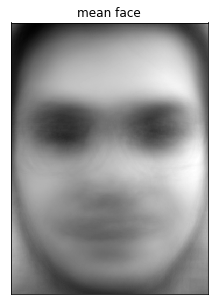

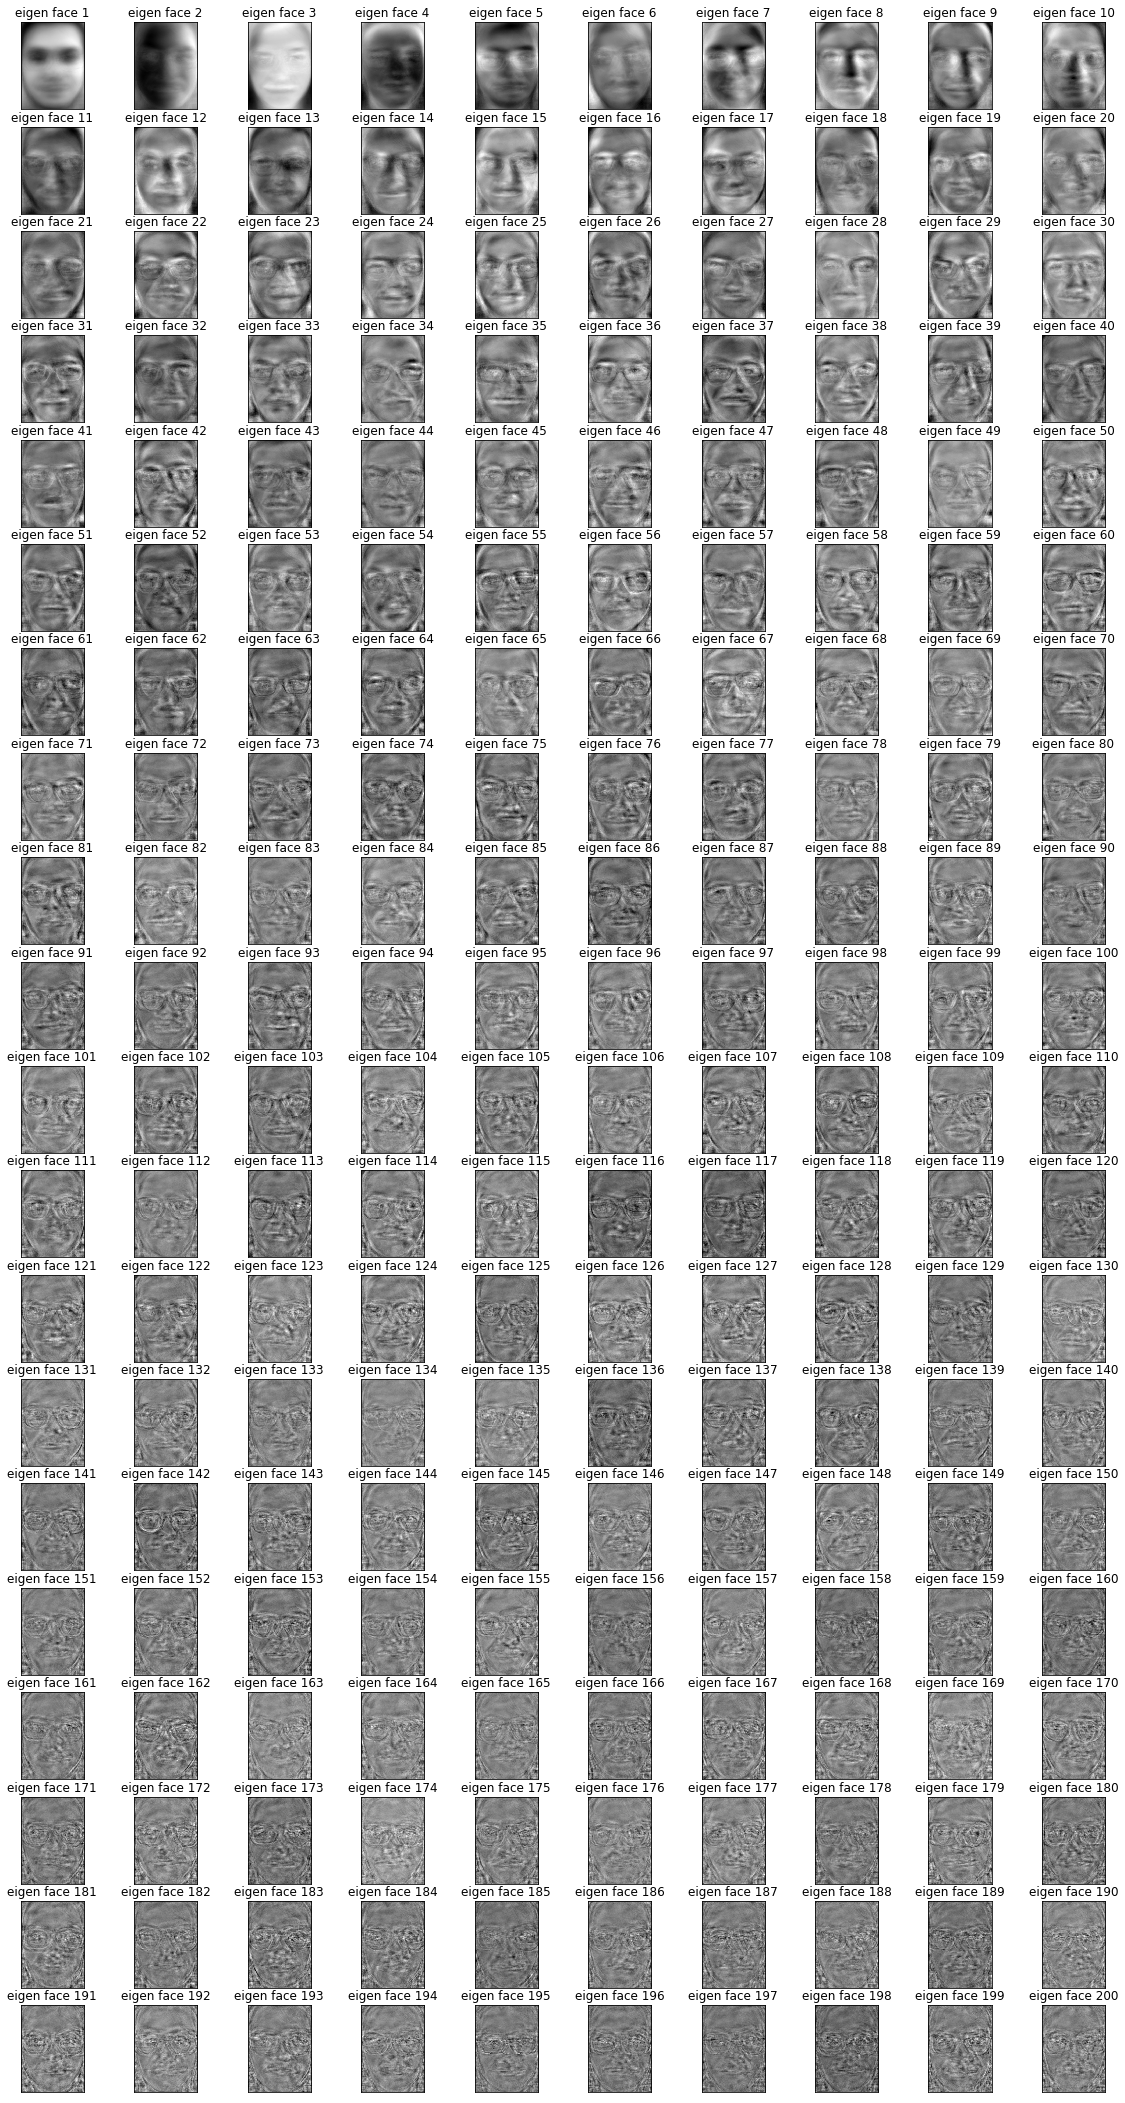

In [0]:
######################### resizing the images ##################################
row = []
col = []
for roi in roi_gray_images:
  row.append(roi.shape[0])
  col.append(roi.shape[1])

row = np.array(row)
col = np.array(col)
dim1 = (int(np.mean(col)) , int(np.mean(row)) )
dim = (int(np.mean(row)), int(np.mean(col)) )

print(dim1)
rois_gray =[]
for roi in roi_gray_images:
  roi  = cv2.resize(roi, dim1, interpolation = cv2.INTER_AREA)
  rois_gray.append(roi)
  
########################  computing the eigen faces ###########################
gamma = np.zeros([rois_gray[0].shape[0]*rois_gray[0].shape[1], len(rois_gray)])
for i, roi in enumerate(rois_gray):
  gamma[:, i] = roi.flatten()[:]

mean_faces = np.true_divide(np.mean(gamma, axis = 1), gamma.shape[1])  
# mean_faces = np.reshape(mean_faces, (mean_faces.shape[0], 1))
A = (gamma.transpose() - mean_faces).transpose()
w, v = LA.eig( np.dot(A.transpose(), A))

plt.imshow(mean_faces.reshape(dim), 'gray')
plt.title('mean face'.format())
plt.xticks([]),plt.yticks([])
plt.show()

k= int(len(rois_gray)*0.5)
# k=5
inds =np.argsort(w)[::-1][:k]
u = np.dot(A, v[:, inds])
u = preprocessing.normalize(u.transpose(), norm='l2').transpose()


plt.figure(figsize=(20,40))
for i in range(u.shape[1]):      
  plt.subplot(int(u.shape[1]/10)+1, 10 ,  i+1)
  plt.imshow(u[:, i].reshape(dim), 'gray')
  plt.title('eigen face '+str(i+1))
  plt.xticks([]),plt.yticks([])
plt.show()


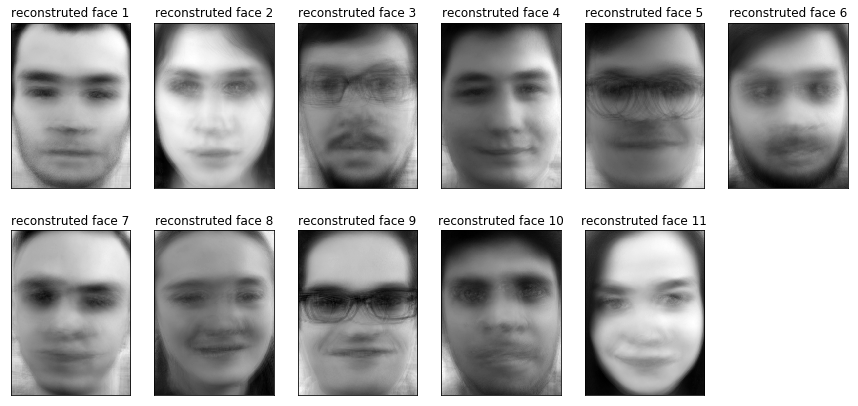

In [0]:
########### projection of the training faces onto the face space ###############
W_total = np.dot(u.transpose(), A) ## weights of each image in columns

W = np.zeros([W_total.shape[0], 11])
### indices of the faces used for weights computation
# index ={0:[7, 11, 19, 24], 1:[1, 2, 18, 28], 2:[22], 3:[26, 30], 4:[3, 13, 17, 33], 5:[41, 44, 46], 6:[5, 10, 27, 37], 7:[0, 20, 25], 8:[29, 40, 43, 45], 9:[12, 21, 39], 10:[4, 9, 31, 34]}

index ={0:np.nonzero(ids ==0)[0].tolist() , 1:np.nonzero(ids ==1)[0].tolist(), 2:np.nonzero(ids ==2)[0].tolist(), 3:np.nonzero(ids ==3)[0].tolist(), 4:np.nonzero(ids ==4)[0].tolist(), 5:np.nonzero(ids ==5)[0].tolist(), 6:np.nonzero(ids ==6)[0].tolist(), 7:np.nonzero(ids ==7)[0].tolist(), 8:np.nonzero(ids ==8)[0].tolist(), 9:np.nonzero(ids ==9)[0].tolist(), 10:np.nonzero(ids ==10)[0].tolist()}

for id in range(11):
  W[:, id] = np.mean(W_total[:, index[id]], axis = 1)
  
A_rec = np.zeros([A.shape[0], W.shape[1]]) ##### matrix A reconstructed from eigen faces 
for i in range (W.shape[1]):
  A_rec[:, i] =  np.sum(np.multiply( u, W[:, i]), axis = 1) + mean_faces

plt.figure(figsize=(15,7))
for i in range(A_rec.shape[1]):      
  plt.subplot(int(A_rec.shape[1]/6)+1, 6 ,  i+1)
  plt.imshow(A_rec[:, i].reshape(dim), 'gray')
  plt.title('reconstruted face '+str(i+1))
  plt.xticks([]),plt.yticks([])
plt.show()



In [0]:
################################## save variables##############################
variables = [dim, dim1, mean_faces, u, W, W_total, index, ids, A]
with open('trainingVariables', 'wb') as f:
    pickle.dump(variables, f)

# Testing:

## face_rec 

In [0]:
def face_rec(image):
  """function that recognizes the person in the given photo 
  input:
    image grayscale or color image with face on it 
  output;
    person_id: id of a person (class)
  """
  from matplotlib import pyplot as plt
  import numpy as np
  import cv2
  from collections import Counter
  import pickle
  from numpy import linalg as LA


  plt.rcParams["figure.figsize"] = (5, 5) # (w, h)

  using_VJ = 0 ######## using Viola Jones for detection
  plot_and_print = 1 ############# plotting the images
  k_dist = 1 ### number of distances taken into account in the voting for the id

  with open('trainingVariables', 'rb') as f:
    dim, dim1, mean_faces, u, W, W_total, index, ids, A = pickle.load(f)

  imgbgr = cv2.imread(image, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  ########################## detecting face ####################################
  if using_VJ:
    ################ using viola Jones
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if (len(faces)==0):
      print('error!! no face detected')
      return -1
    for (x,y,w,h) in faces:
      cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
      roi_gray = gray[y:y+h, x:x+w]
      roi_color = img[y:y+h, x:x+w]
      if len(faces) > 1:
        return -1
  else:
    ################ using deep learning
    modelFile = "opencv_face_detector_uint8.pb"
    configFile = "opencv_face_detector.pbtxt"
    net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)
    conf_threshold = 0.9

    (h, w) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), [104, 117, 123], False, False)
    net.setInput(blob)
    detections = net.forward()
    
    detect = 0
    if detections.shape[2]==0:
      return -1
    for k in range(detections.shape[2]):
      confidence = detections[0, 0, k, 2]
      if confidence > conf_threshold:
        box = detections[0, 0, k, 3:7] * np.array([w, h, w, h])
        roi_gray = gray[int(box[1]) : int(box[3]) , int(box[0]) : int(box[2])]
        roi_color = img[int(box[1]) : int(box[3]) , int(box[0]) : int(box[2])]
        detect = 1
    if detect ==0:
      return -1

  ######################### resizing the image face#############################
  roi  = cv2.resize(roi_gray, dim1, interpolation = cv2.INTER_AREA)

  ################### projection  onto the face space ##########################
  gamma_test = roi.flatten()[:]
  phi_test =(gamma_test.transpose() - mean_faces).transpose()
  w_test = np.dot(u.transpose(), phi_test) ## weights of each image in columns
  dist= []
  
  for i in range (W_total.shape[1]):
    dist.append( LA.norm(w_test - W_total[:, i]) ) ### euclidean distance 

  ###################### voting for the best minimum distance ################
  distance = dist
  indices = []
  for i in range(k_dist):
    ind = np.argmin(distance)
    distance.pop(ind)
    indices.append(ind)

  occur = Counter(ids[indices])
  min_occur = 0
  if len( set(ids[indices]) ) ==1:
    ind = indices[0]
    person_id  = ids[ind]
  else:
    for id, oc in occur.items():
      if oc > min_occur:
        min_occur = oc
        person_id = id
  ind = index[person_id][0]
    
  if plot_and_print:
    ######################### plot the input image ##############################""
    plt.figure(figsize=(20,5))
    plt.subplot(1,4,1)
    plt.imshow(img, 'gray')
    plt.title('input image'.format())
    plt.xticks([]),plt.yticks([])

    ########################  plotting face ######################################
    plt.subplot(1,4,2)
    plt.imshow(roi_color, 'gray')
    plt.title('detected face'.format())
    plt.xticks([]),plt.yticks([])

    ################## plotting identified and reconstructed face ################
    plt.subplot(1,4,3)
    plt.imshow((A[:, ind]  + mean_faces).reshape(dim), 'gray')
    plt.title('identified face')
    plt.xticks([]),plt.yticks([])

    A_rec =  np.sum(np.multiply( u, w_test), axis = 1) + mean_faces 
    plt.subplot(1,4,4)
    plt.imshow(A_rec.reshape(dim), 'gray')
    plt.title('reconstruted face ')
    plt.xticks([]),plt.yticks([])
    plt.show()
  
    #################### printing distance within and from face space ############
    difs = dist[ind]
    dffs = LA.norm(np.sum(np.multiply( u, w_test), axis = 1) -phi_test)
    print('the distance within the face space is difs = :{}'.format(difs))  
    print('the distance from the face space is dffs = :{}'.format(dffs)) 
    print('the face identified is id = {}'.format(person_id))  

  
  return person_id

## main code



In [0]:
############################### main code ######################################

image = 'test_0_4415.jpg'
person_id = face_rec(image)

In [0]:

######################## precision computation #################################
list_of_testfiles = glob.glob('*.jpg')           # create the list of file
false_images = []
precision =[]
for image in (list_of_testfiles):
  if image.split('_')[0]=='test':  
    id = int(image.split('_')[1])
    person_id = face_rec(image)
    print('the face identified is id = {}, the true face is id = {}'.format(person_id, id))  
    if person_id !=-1:
      precision.append(id == person_id)
    if id!= person_id:
      false_images.append(image)
accuracy =  sum(precision) / len(precision)
print('the precision of the face recognition algorithm is {}'.format(accuracy))